# <div align="center"> ASIIGNMENT 5</div>
## <div align="center"> GROUP 4 </div> 
### <div align="center">DINESH PATEL(23510032)(CONTRIBUTION:50%)</div>
### <div align="center">TARUN KUMAR(23510125)(CONTRIBUTION:50%)</div>


### Q : 1-8 (7 in another attached File)

### -- Import Libraries

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from scipy.stats import expon, vonmises
from scipy.signal import correlate
import corner

### --Load data from CSV

In [153]:
data = pd.read_csv('data.csv' , names = ['t' , 'd(t)'])
t = data['t'].values
d_t = data['d(t)'].values

### --Define the model G(t; theta)

The sine-Gaussian model is given by:

$$
G(t; A, t_0, \tau, f_0, \phi_0) = A \exp\left(-\frac{(t - t_0)^2}{\tau^2}\right) \sin\left(2 \pi f_0 t + \phi_0\right)
$$

Where:
- $A$ -- is the amplitude of the signal,
- $t_0$ -- is the central time,
- $\tau$ -- is the width of the Gaussian envelope,
- $f_0$ -- is the central frequency,
- $\phi_0$ -- is the phase offset.


In [157]:
def sine_gaussian(t, A, t0, tau, f0, phi0):
    return A * np.exp(-((t - t0)**2) / tau**2) * np.sin(2 * np.pi * f0 * t + phi0)

### -- Log Likelihood
The likelihood function represents the probability of observing the data $ d(t) $ given a particular set of model parameters $ \theta $. In this case, the data are assumed to be a combination of the signal $ G(t; \theta) $ and Gaussian noise $ \eta(t) $, i.e.,

$$ d(t) = G(t; \theta) + \eta(t), $$

where $ \eta(t) \sim \mathcal{N}(0, \sigma = 0.1) $, meaning that the noise follows a normal distribution with zero mean and standard deviation $ \sigma = 0.1 $.

The likelihood function for the observed data $ d(t) $ is:

$$ f(d \mid \theta) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(d(t_i) - G(t_i; \theta))^2}{2\sigma^2}\right), $$

where $ t_i $ denotes the time points at which the data is sampled, and $ N $ is the total number of time samples.

In [160]:
def log_likelihood_gaussian(theta, t, d_t, sigma=0.1):
    A, t0, tau, f0, phi0 = theta
    model = sine_gaussian(t, A, t0, tau, f0, phi0)
    residual = d_t - model
    return -0.5 * np.sum((residual / sigma)**2)

### 2. Expression for the Posterior Distribution $ q(\theta \mid d) $

The posterior distribution combines the likelihood function with a prior distribution $ \pi(\theta) $ over the model parameters. Assuming a uniform (flat) prior distribution for each parameter, we have:

$$ \pi(A) \equiv U(0, 1.5), $$

$$ \pi(t_0) \equiv U(0, 4) $$  

$$ \pi(\tau) \equiv U(0, 1), $$

$$ \pi(f_0) \equiv U(0, 5), $$

$$ \pi(\phi_0) \equiv U(0, 2\pi). $$

The posterior distribution is given by Bayes' theorem:

$$ q(\theta \mid d) \propto f(d \mid \theta) \pi(\theta). $$

Substituting the expressions for the likelihood and the prior, we get:

$$ q(\theta \mid d) \propto \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{N} (d(t_i) - G(t_i; \theta))^2 \right) \pi(A) \pi(t_0) \pi(\tau) \pi(f_0) \pi(\phi_0). $$

Since the prior distributions are uniform, they are constant over their respective ranges, and we are left with the form of the posterior:

$$ q(\theta \mid d) \propto \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{N} (d(t_i) - G(t_i; \theta))^2 \right). $$

#### Step 1: Define the Proposal Distribution
The proposal distribution $ r(\theta' \mid \theta) $ generates a new set of parameters $ \theta' $ given the current parameters $ \theta $. A simple choice is a multivariate Gaussian:

$$ r(\theta' \mid \theta) = \mathcal{N}(\theta, \sigma_r^2), $$

where $ \sigma_r^2 $ is a tuning parameter that determines the spread of the proposal distribution.


### Log-Prior Function

The **log-prior** function is defined as follows:

$$
\text{log\_prior}(\theta) =
\begin{cases}
0 & \text{if } 0 < A < 10, 0 < t_0 < 4, 0 < \tau < 1, 0 < f_0 < 5, 0 < \phi_0 < 2\pi \\
-\infty & \text{otherwise}
\end{cases}
$$

Where $ \theta = (A, t_0, \tau, f_0, \phi_0) $ represents the model parameters, and the prior is uniform over the specified ranges.



In [165]:
def log_prior(theta):
    A, t0, tau, f0, phi0 = theta
    if 0 < A < 1.5 and 0 < t0 < 4 and 0 < tau < 1 and 0 < f0 < 5 and 0 < phi0 < 2 * np.pi:
        return 0  # log(1) for uniform prior
    return -np.inf  # log(0)

### Log-Posterior Function

The **log-posterior** function combines the log-prior and the log-likelihood as follows:

$$
\text{log\_posterior}(\theta, t, d_t, \sigma) = \text{log\_prior}(\theta) + \text{log\_likelihood}(\theta, t, d_t, \sigma)
$$

Where:
- $ \text{log\_prior}(\theta) $ is the log-prior (defined above),
- $ \text{log\_likelihood}(\theta, t, d_t, \sigma) $ is the log-likelihood function, which quantifies the likelihood of the data given the model parameters.
- If the prior is not valid (i.e., it returns $ -\infty $), the log-posterior is also set to $ -\infty $, effectively rejecting the sample.


In [168]:
def log_posterior_gaussian(theta, t, d_t, sigma=0.1):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian(theta, t, d_t, sigma)

### Metropolis-Hastings Sampler for MCMC

The **Metropolis-Hastings** algorithm is a method for sampling from a posterior distribution in Markov Chain Monte Carlo (MCMC). Here's a summary of the algorithm:

#### 1. Initialization
We start with an initial guess for the parameters $ \theta_{\text{init}} $, which is a vector of model parameters.

#### 2. Proposing New Samples
In each iteration of the algorithm, a new sample $ \theta_{\text{proposed}} $ is proposed by adding random noise to the current sample:

$$
\theta_{\text{proposed}} = \theta_{\text{current}} + \mathcal{N}(0, \sigma^2)
$$

Where $ \mathcal{N}(0, \sigma^2) $ is a Gaussian distribution centered at 0 with standard deviation $ \sigma $ (represented by `proposal_std`).

#### 3. Calculating the Acceptance Probability
We calculate the **log acceptance ratio** $ \log(\alpha) $, which is the difference between the log-posterior of the proposed sample and the log-posterior of the current sample:

$$
\log(\alpha) = \log(\pi(\theta_{\text{proposed}} | d)) - \log(\pi(\theta_{\text{current}} | d))
$$

Where $ \pi(\theta | d) $ is the posterior distribution (calculated as the sum of the log-likelihood and log-prior). The acceptance probability is given by:

$$
\alpha = \exp(\log(\alpha))
$$

#### 4. Accept or Reject the Proposed Sample
We accept the proposed sample $ \theta_{\text{proposed}} $ with probability $ \alpha $. If the random number $ u \sim \mathcal{U}(0, 1) $ is less than $ \alpha $, we accept the proposed sample and set $ \theta_{\text{current}} = \theta_{\text{proposed}} $.

#### 5. Storing Accepted Samples
The accepted (or current) sample $ \theta_{\text{current}} $ is added to the list of samples.

#### 6. Output
The algorithm returns the array of **generated samples** and the **number of accepted proposals**.

### **Proposal Distribution Choice**

- The **Metropolis-Hastings** algorithm uses a proposal distribution $r(\theta' | \theta) $ to sample new parameter values.
- We choose a **Gaussian (Normal) distribution** centered at the current parameter value $\theta $.

$$
r(\theta' | \theta) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left(-\frac{(\theta'_i - \theta_i)^2}{2 \sigma_i^2}\right)
$$

where:
- $ \theta = [A, t_0, \tau, f_0, \phi_0] $ is the current parameter vector.
- $ \theta' =[A', t'_0, \tau', f'_0, \phi'_0] $ is the proposed parameter vector.
- $ \sigma_i $ is the standard deviation for the $ i $-th parameter.

---

### **Why Gaussian Proposal Distribution?**

1. **Simplicity**:  
   - Easy to implement and computationally efficient.

2. **Symmetry**:  
   - The Gaussian is symmetric, i.e., $ r(\theta' | \theta) = r(\theta | \theta') $, simplifying the acceptance ratio:

   $$
   \alpha = \min\left(1, \frac{p(\theta')}{p(\theta)}\right)
   $$

3. **Adaptability**:  
   - The step size $ \sigma_i $ can be tailored for each parameter based on its scale and sensitivity.

---

### **Trade-off in $ \sigma $:**

1. **Large $ \sigma $:**  
   - Leads to larger jumps in parameter space.  
   - May lower acceptance rates if proposals fall outside high-probability regions.

2. **Small $ \sigma $:**  
   - Leads to smaller jumps, ensuring high acceptance rates.  
   - Slows down convergence as the parameter space is explored inefficiently.

---

In [172]:
def metropolis_hastings(log_posterior, theta_init, n_samples, proposal_std, t, d_t):
    """
    Metropolis-Hastings sampler for MCMC.
    
    Args:
        log_posterior (function): Function to calculate the log posterior.
        theta_init (array): Initial parameter vector.
        n_samples (int): Number of samples to generate.
        proposal_std (array): Standard deviations for the Gaussian proposal.
        t (array): Time data.
        d_t (array): Observed data.
    
    Returns:
        samples (array): Generated samples.
        accepted (int): Number of accepted proposals.
    """
    theta_current = np.array(theta_init)
    samples = []
    Theta_proposeds = []
    Theta_currents = []
    accepted = 0
    
    for _ in range(n_samples):
        # Propose new parameters
        theta_proposed = np.random.normal(theta_current, proposal_std)
        
        # Calculate acceptance probability
        log_alpha = log_posterior(theta_proposed, t, d_t) - log_posterior(theta_current, t, d_t)
        alpha = np.exp(log_alpha)
        
        # Accept or reject
        if np.random.rand() < alpha:
            theta_current = theta_proposed
            accepted += 1

        Theta_currents.append(theta_current)
        Theta_proposeds.append(theta_proposed)
        
        samples.append(theta_current)
    
    return np.array(samples), accepted , np.array(Theta_currents) , np.array(Theta_proposeds)

In [174]:
theta_init = [1.0, 2.0, 0.5, 2.0, np.pi]

samples, accepted , Theta_currents , Theta_proposeds = metropolis_hastings(log_posterior_gaussian, theta_init, 10000, 0.8, t, d_t)

#### -- Plot samples for different parameters 

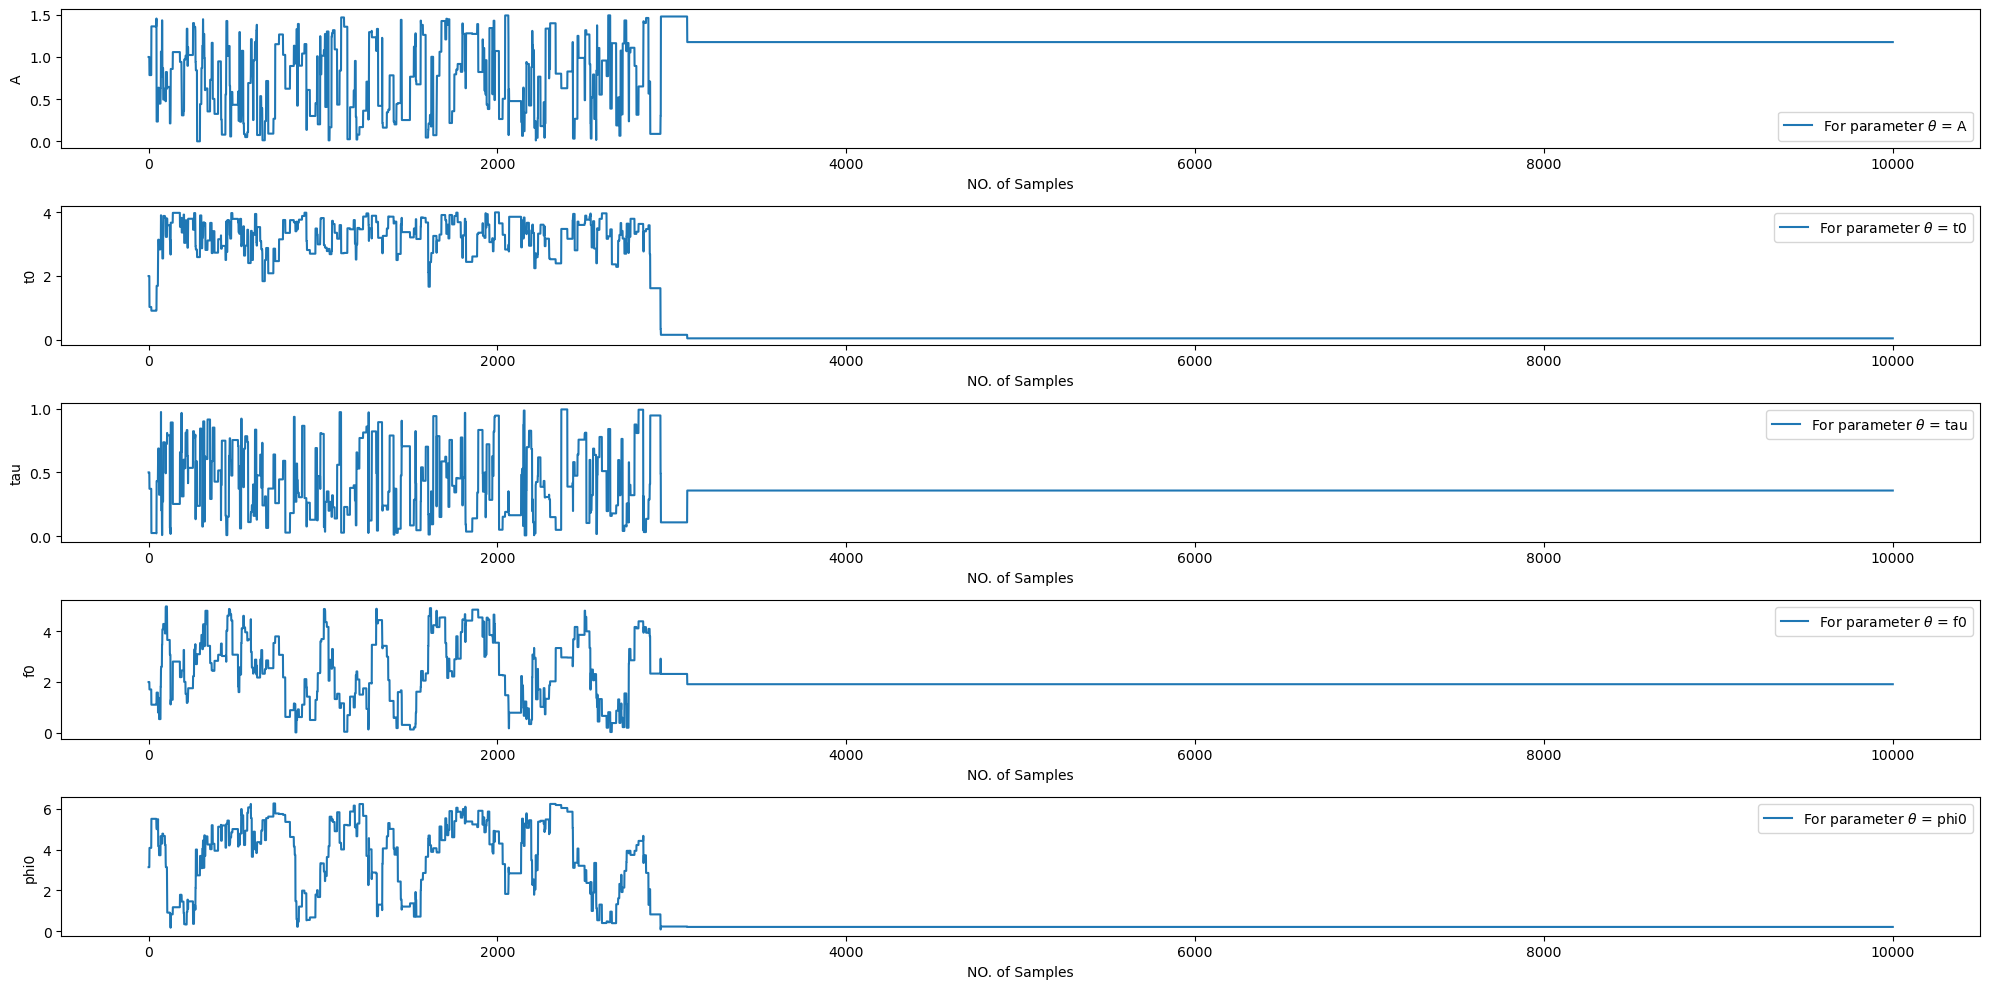

In [177]:
fig = plt.figure(figsize=(20 , 10))
labels=["A", "t0", "tau", "f0", "phi0"]
for i in range(5):
    ax = fig.add_subplot(5 ,1 ,i+1)
    ax.plot(samples[:,i] , label = f'For parameter $ \\theta $ = {labels[i]}' )
    ax.set_xlabel('NO. of Samples')
    ax.set_ylabel(f'{labels[i]}')
    ax.legend()
plt.tight_layout()
plt.show()

##### Here we can see that after initial burn in phase our parameter value becomes stable( Not fluctuating too much ). Hence we can sample our parameter values after burn in phase

### -- Plot Histogram of Stable samples 

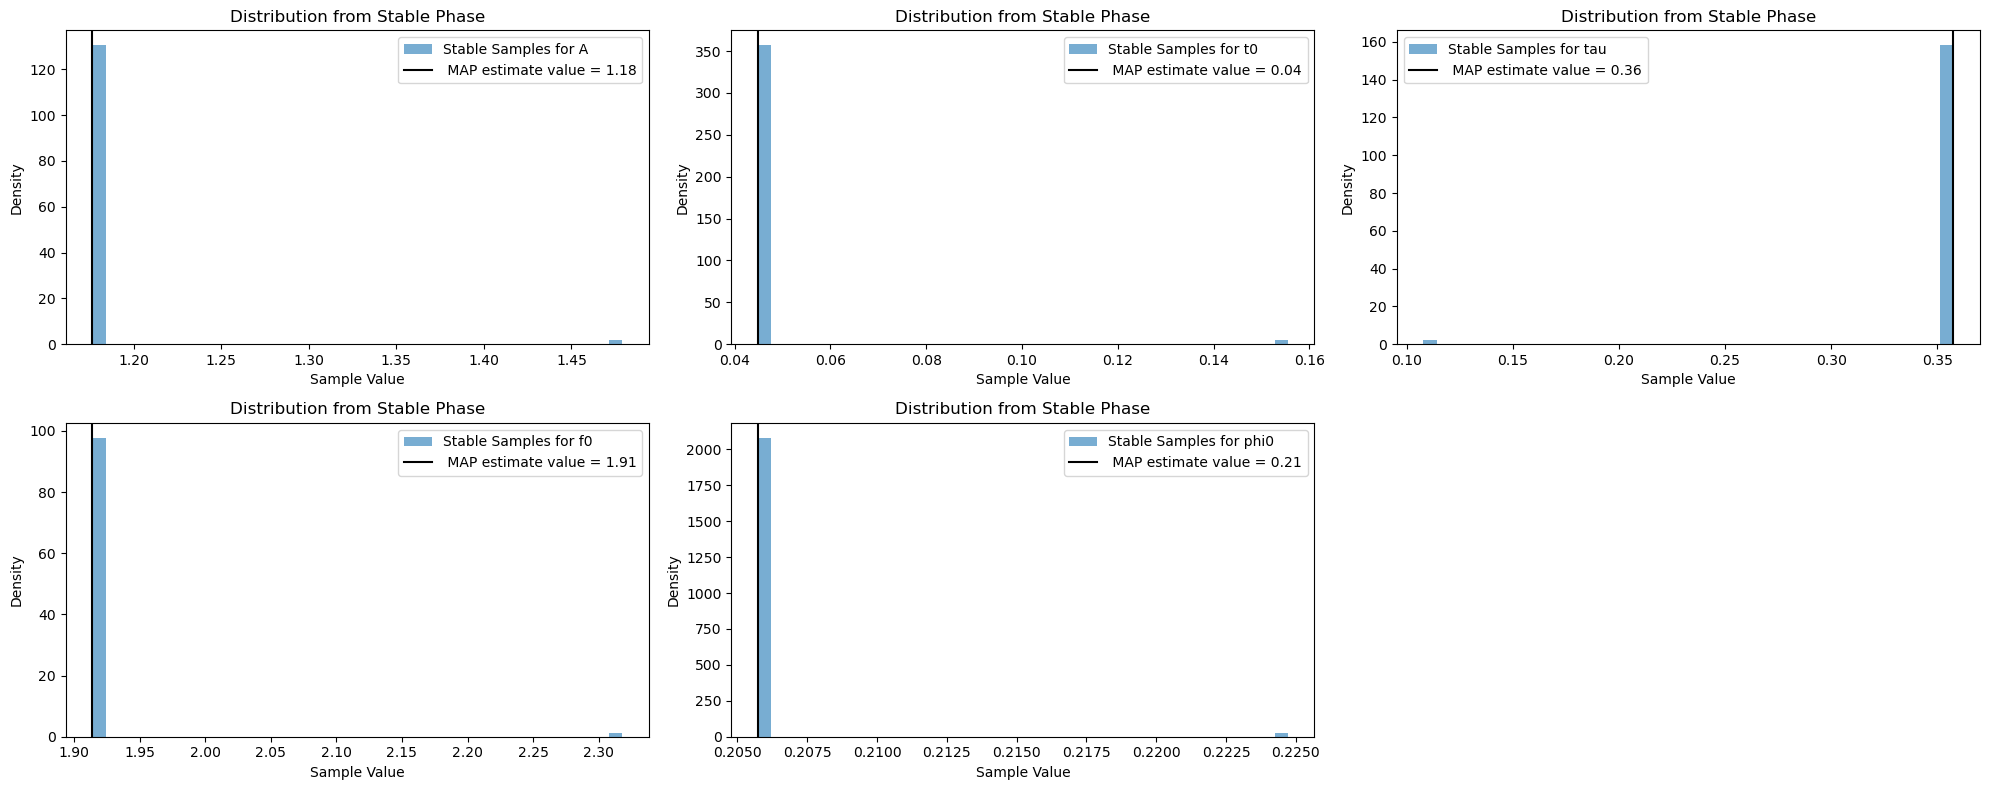

In [181]:
# -- map values based on maximizing the posterior dist
map_estimate_gaussian = samples[np.argmax([log_posterior_gaussian(s, t, d_t) for s in samples])]

burn_in = 3000

labels=["A", "t0", "tau", "f0", "phi0"]
Mean_param_gaussian = []
Std_param = []

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    stable_samples = samples[burn_in: , i]
    Mean_param_gaussian.append(np.mean(stable_samples))
    Std_param.append(np.std(stable_samples))
    ax = fig.add_subplot(2 , 3 , i+1)
    ax.hist(stable_samples, bins=40, density=True, alpha=0.6, label=f"Stable Samples for {labels[i]} ")
    ax.axvline(x = map_estimate_gaussian[i] , color = 'black', label = f' MAP estimate value = {round(map_estimate_gaussian[i] , 2)}')
    ax.set_title("Distribution from Stable Phase")
    ax.set_xlabel("Sample Value")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
plt.show()


### -- Plot actual sine-gaussian model with added noise and the estimated model with sampled values of parameters 

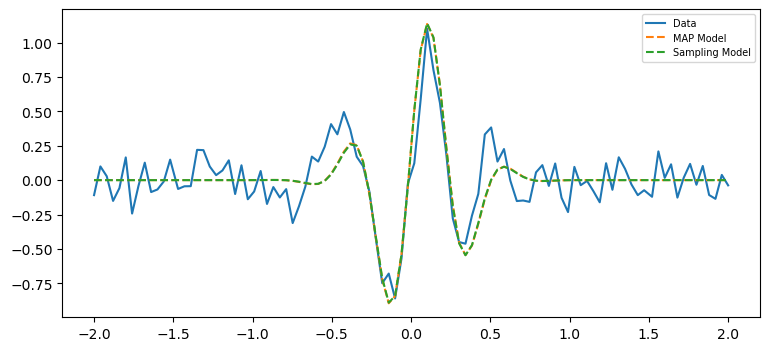

In [184]:
plt.figure(figsize=(9,4))
plt.plot(t, d_t, label="Data")
plt.plot(t, sine_gaussian(t, *map_estimate_gaussian), label="MAP Model", linestyle="--")
plt.plot(t ,sine_gaussian(t, *Mean_param_gaussian), label="Sampling Model", linestyle="--")
plt.legend(fontsize = 7)
plt.show()

### -- Plot corner plot

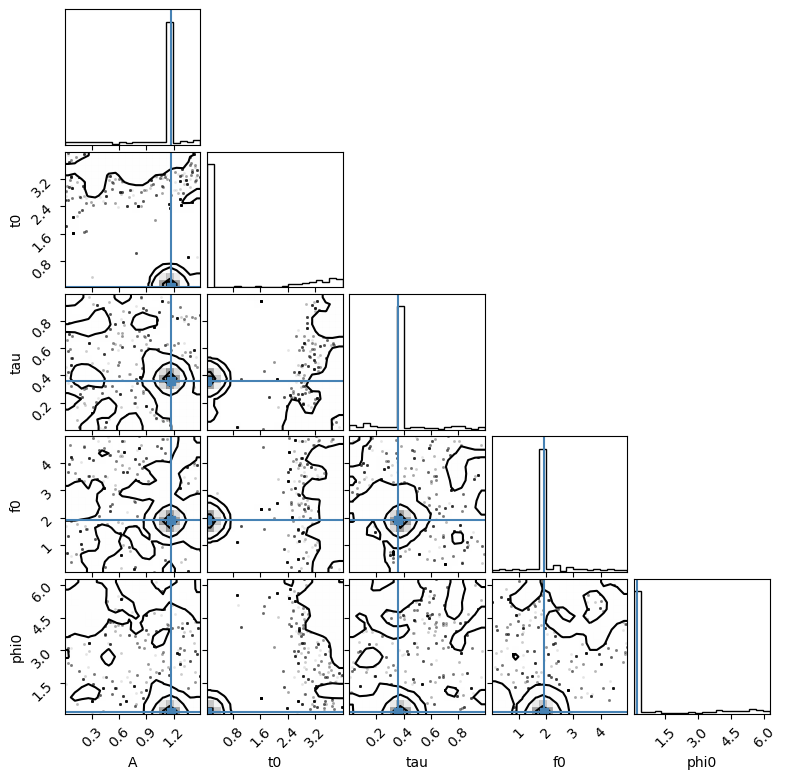

In [187]:
fig = plt.figure(figsize=(8,8)) 
plt.close()

corner.corner(
    samples,
    labels=["A", "t0", "tau", "f0", "phi0"],
    truths=map_estimate_gaussian,
    smooth=1,
    fig=fig )


### - Now check Auto-Corellation between $ ( \theta_i  , \theta_{i+1} ) $

In [190]:
# Calculate autocorrelation at lag 1
def autocorrelation(x):
    """Compute the autocorrelation at lag 1."""
    n = len(x)
    mean_x = np.mean(x)
    numerator = np.sum((x[1:] - mean_x) * (x[:-1] - mean_x))
    denominator = np.sum((x - mean_x) ** 2)
    return numerator / denominator

# Calculate autocorrelation for each parameter in the samples
correlations = autocorrelation(samples[burn_in:, 0])
print(f"Correlation coefficient between theta_current and theta_previous is {round(correlations, 3)}")

Correlation coefficient between theta_current and theta_previous is 0.989


### Hence $ ( \theta_i  , \theta_{i+1} ) $ are highely correlated. Th

### Fisher Information 



### 1. **Understanding Fisher Information Matrix (FIM)**

The Fisher Information Matrix is defined as:

$$
I_{ij} = -\mathbb{E}\left[\frac{\partial^2 \log \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_i \partial \theta_j}\right]
$$

Where $ \log \mathcal{L}(\boldsymbol{\theta}) $ is the log-likelihood function. For Gaussian noise, the FIM simplifies to:

$$
I_{ij} = \frac{1}{\sigma^2} \sum_{k=1}^{N} \frac{\partial G(t_k; \boldsymbol{\theta})}{\partial \theta_i} \frac{\partial G(t_k; \boldsymbol{\theta})}{\partial \theta_j}
$$

Here:
- $ G(t; \boldsymbol{\theta}) $ is the model function.
- $ \frac{\partial G}{\partial \theta_i} $ are the partial derivatives of the model with respect to the parameters.

---

### 2. **Covariance Matrix**

The covariance matrix $ \Sigma $ is the inverse of the Fisher Information Matrix:

$$
\Sigma = I^{-1}
$$


1. **Fisher Information Matrix**: Quantifies how much information the data provides about the parameters.
2. **Covariance Matrix**: Diagonal elements represent the variance of the parameter estimates. The square root of the diagonal elements gives the parameter uncertainties.

---

### Define Partial Derivative

In [196]:
def partial_derivative(model, t, theta, param_index, epsilon=1e-4):
    perturbed_theta = theta.copy()
    perturbed_theta[param_index] += epsilon
    model_plus = model(t, *perturbed_theta)
    
    perturbed_theta[param_index] -= 2 * epsilon
    model_minus = model(t, *perturbed_theta)
    
    derivative = (model_plus - model_minus) / (2 * epsilon)
    return derivative

### Fisher Information Matrix

In [199]:
def fisher_information_matrix(model, t, d_t, theta, sigma=0.1):
    n_params = len(theta)
    FIM = np.zeros((n_params, n_params))
    
    for i in range(n_params):
        for j in range(n_params):
            # Compute partial derivatives
            derivative_i = partial_derivative(model, t, theta, i)
            derivative_j = partial_derivative(model, t, theta, j)
            
            # Compute Fisher Information matrix element
            FIM[i, j] = np.sum(derivative_i * derivative_j) / sigma**2
    
    return FIM

### Covarience Matrix

In [202]:
def covariance_matrix(FIM):
    return np.linalg.inv(FIM)

In [204]:
# Calculate Fisher Information and Covariance Matrices
FIM = fisher_information_matrix(sine_gaussian, t, d_t, map_estimate_gaussian, sigma=0.1)
cov_matrix = covariance_matrix(FIM)

# Labels for parameters
labels = ["A", "t0", "tau", "f0", "phi0"]

# Convert to DataFrames with rounded values
fim_df = pd.DataFrame(np.round(FIM, 4), index=labels, columns=labels)
cov_df = pd.DataFrame(np.round(cov_matrix, 4), index=labels, columns=labels)

# Print matrices as formatted tables
print("Fisher Information Matrix (Rounded):")
print(fim_df)

Fisher Information Matrix (Rounded):
             A         t0        tau         f0      phi0
A     554.9413     1.2147   911.3220     1.2438    0.2499
t0      1.2147  5995.4775   -17.8510    -2.4892    3.4355
tau   911.3220   -17.8510  4489.7447     1.8663   -1.5389
f0      1.2438    -2.4892     1.8663  1030.0859  215.6359
phi0    0.2499     3.4355    -1.5389   215.6359  767.3538


### Larger diagonal values indicate higher precision in estimating that parameter.
### "From the Fisher Information Matrix, we can infer that the model contains more information about the parameters $t_0$ and $\tau $ compared to the other parameters."

## Extra Part 

### Step 1: Define the Function
The given function is:

$$
G(t; \vec{\theta}) = A \left( \frac{\tau^2}{(t - t_0)^2 + \tau^2} \right) \sin\left(2 \pi f_0 t + \phi_0\right)
$$

Here, the parameters to estimate are:

$$
\vec{\theta} = [A, t_0, \tau, f_0, \phi_0]
$$

---

### Step 2: Define the Likelihood Function
Assuming Gaussian noise in the observed data $ d_t $, the log-likelihood can be defined as:

$$
\log L(\vec{\theta}) = -\frac{1}{2} \sum \left(\frac{d_t - G(t; \vec{\theta})}{\sigma}\right)^2
$$


In [209]:
def sine_damped(t, A, t0, tau, f0, phi0):
    return A * (tau**2 / ((t - t0)**2 + tau**2)) * np.sin(2 * np.pi * f0 * t + phi0)

def log_likelihood_damped(theta, t, d_t, sigma=0.1):
    A, t0, tau, f0, phi0 = theta
    model = sine_damped(t, A, t0, tau, f0, phi0)
    residual = d_t - model
    return -0.5 * np.sum((residual / sigma)**2)

def log_posterior_damped(theta, t, d_t, sigma=0.1):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_damped(theta, t, d_t, sigma)

In [211]:
theta_init = [1.0, 2.0, 0.5, 2.0, np.pi]

samples, accepted , Theta_currents , Theta_proposeds = metropolis_hastings(log_posterior_damped, theta_init, 10000, 0.9, t, d_t)

### Plot Samples for different parameters

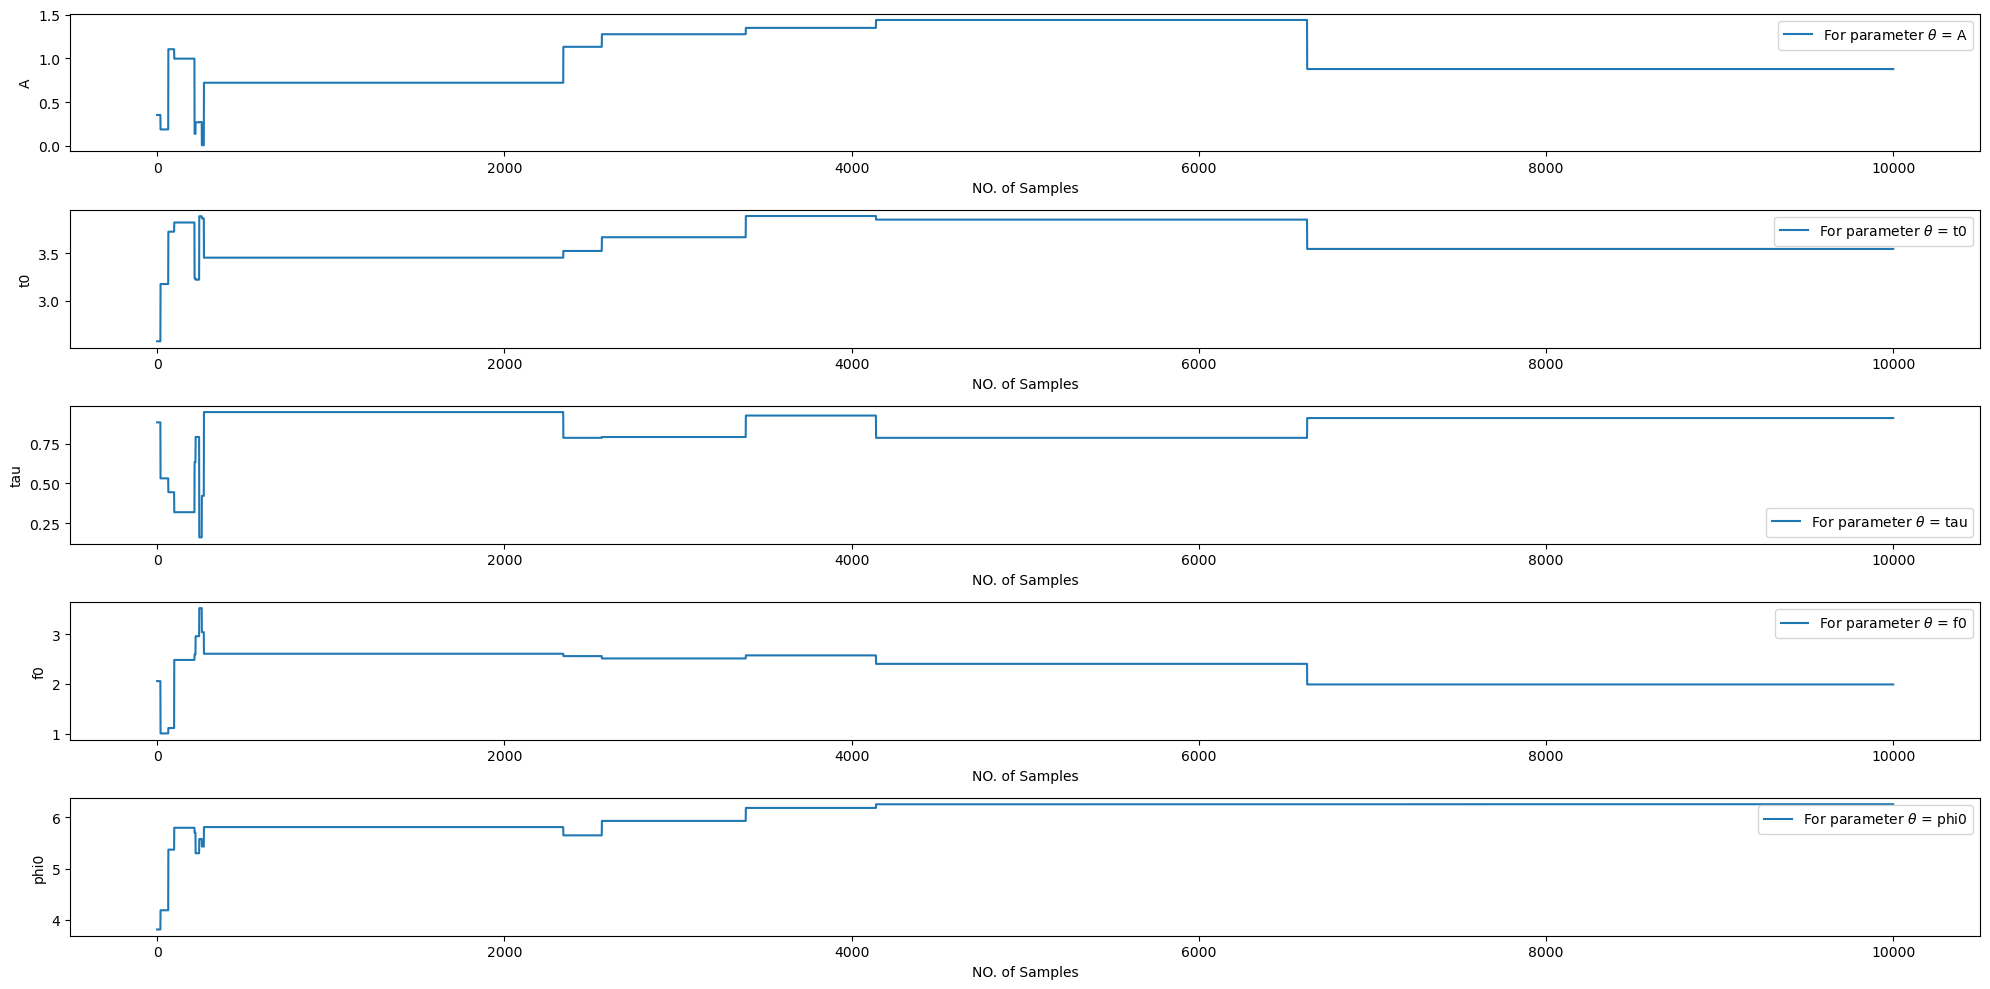

In [214]:
fig = plt.figure(figsize=(20 , 10))
labels=["A", "t0", "tau", "f0", "phi0"]
for i in range(5):
    ax = fig.add_subplot(5 ,1 ,i+1)
    ax.plot(samples[:,i] , label = f'For parameter $ \\theta $ = {labels[i]}' )
    ax.set_xlabel('NO. of Samples')
    ax.set_ylabel(f'{labels[i]}')
    ax.legend()
plt.tight_layout()
plt.show()

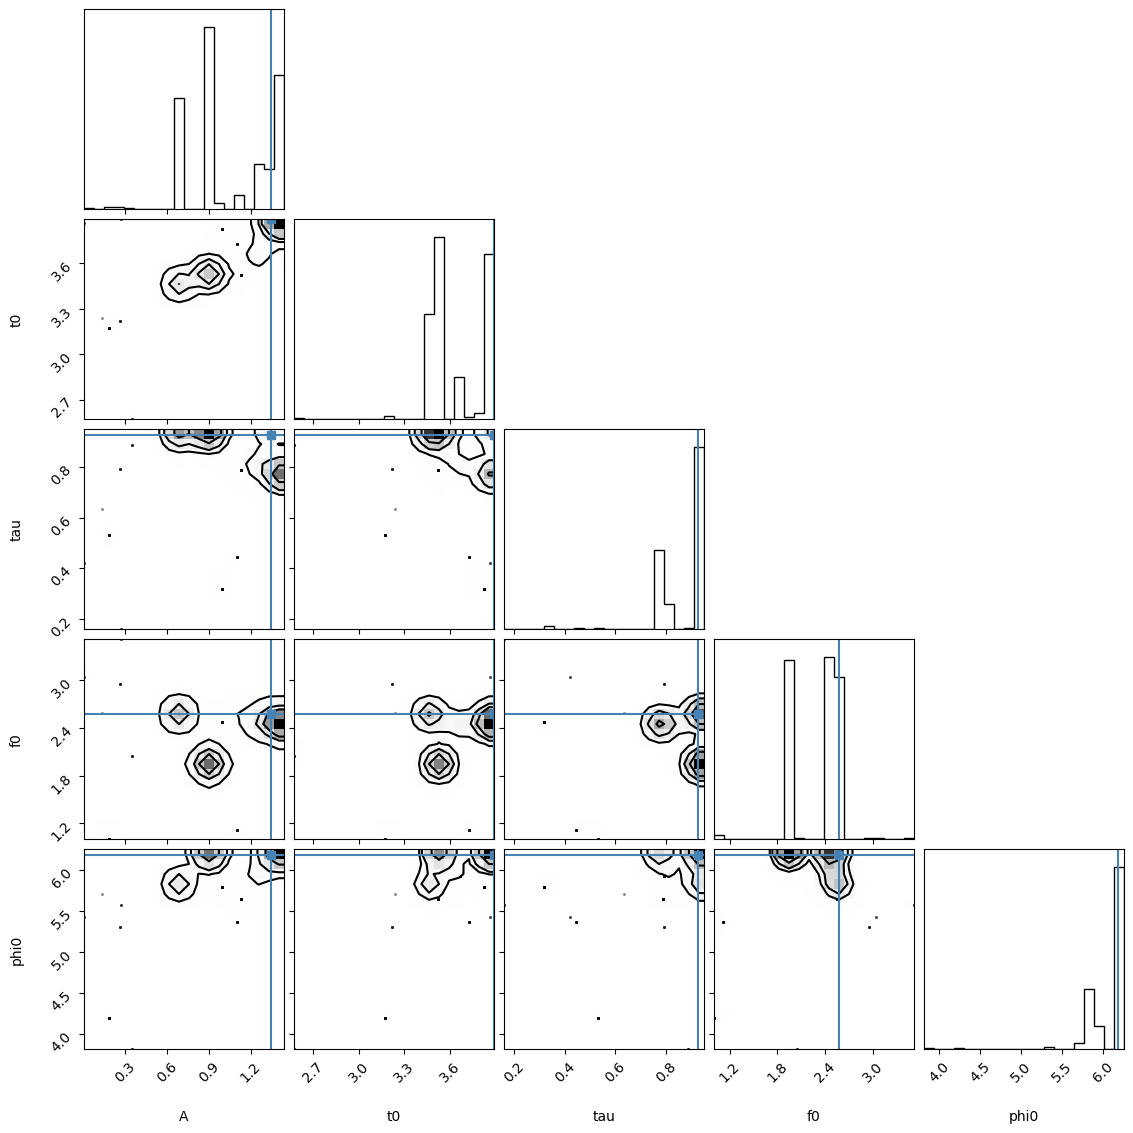

In [216]:
# Maximum a posteriori (MAP) estimate
map_estimate_damped = samples[np.argmax([log_posterior_damped(s, t, d_t) for s in samples])]

# Plot corner plot
fig = corner.corner(samples, labels=["A", "t0", "tau", "f0", "phi0"], truths=map_estimate_damped , smooth  = 1)
plt.show()

### Plot Histogram

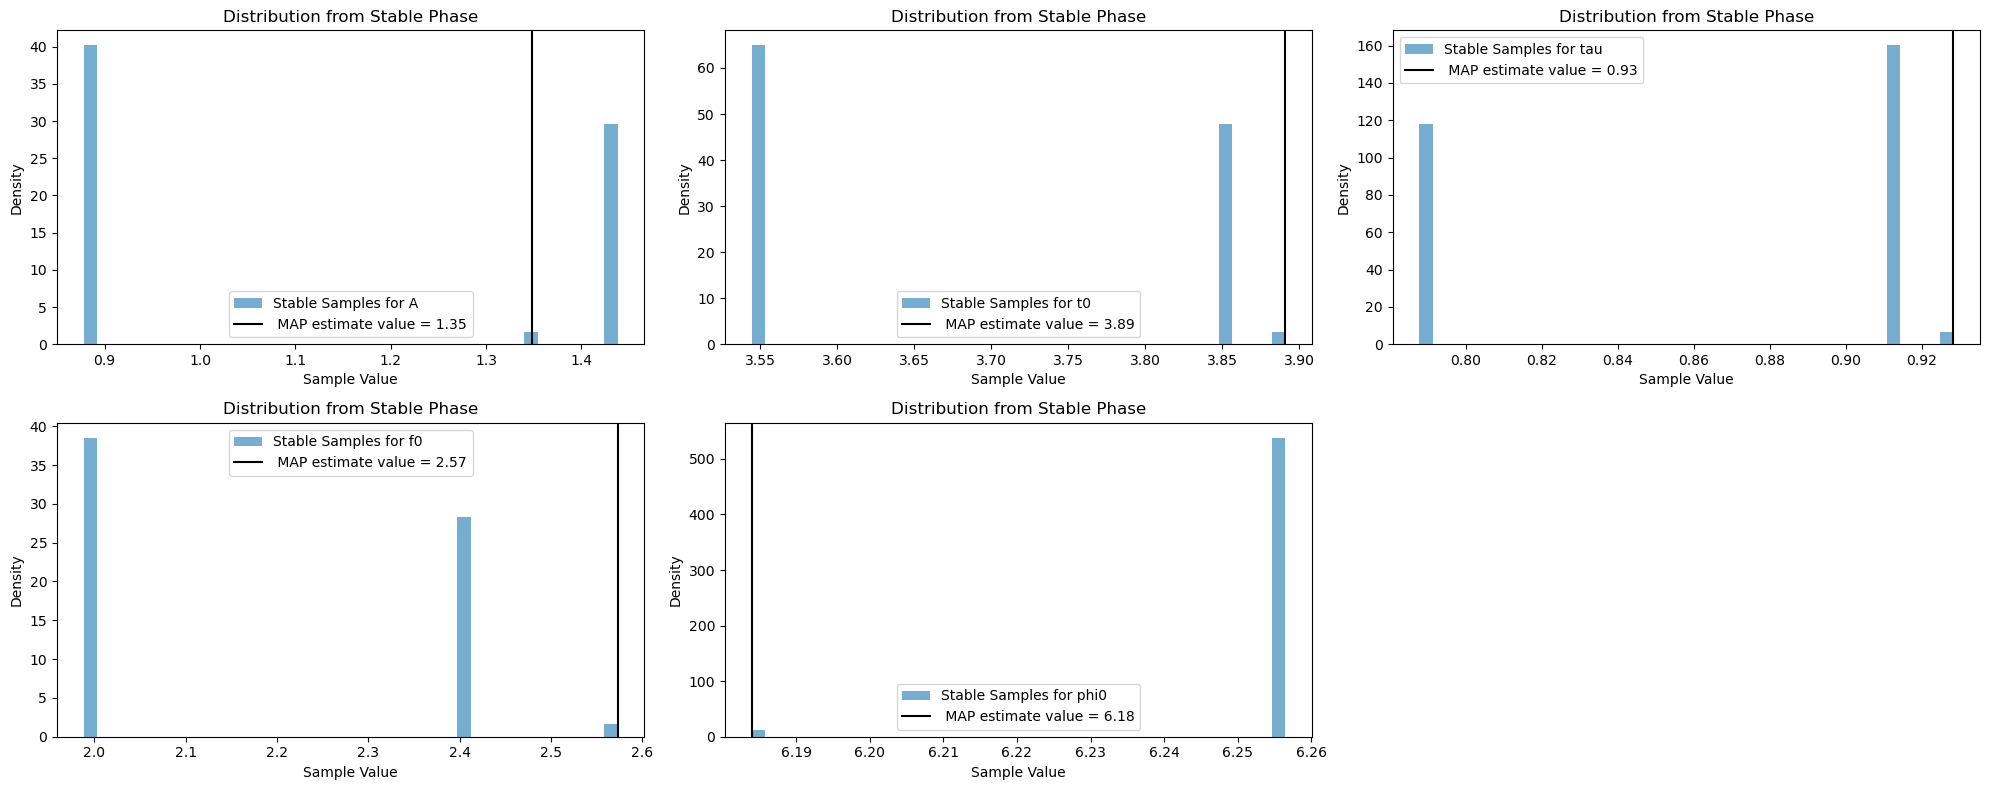

In [219]:

burn_in = 4000

labels=["A", "t0", "tau", "f0", "phi0"]
Mean_param_damped = []
Std_param = []

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    stable_samples = samples[burn_in: , i]
    Mean_param_damped.append(np.mean(stable_samples))
    Std_param.append(np.std(stable_samples))
    ax = fig.add_subplot(2 , 3 , i+1)
    ax.hist(stable_samples, bins=40, density=True, alpha=0.6, label=f"Stable Samples for {labels[i]} ")
    ax.axvline(x = map_estimate_damped[i] , color = 'black', label = f' MAP estimate value = {round(map_estimate_damped[i] , 2)}')
    ax.set_title("Distribution from Stable Phase")
    ax.set_xlabel("Sample Value")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
plt.show()


#### Plot for Sine-Damped Model 

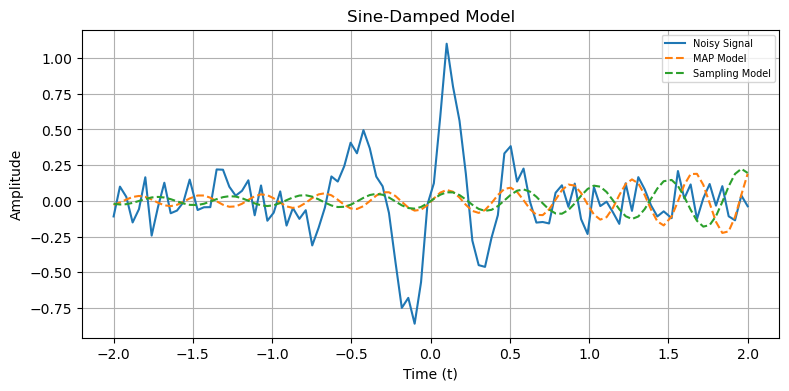

In [222]:
# Plot the sine-damped model and the noisy signal
plt.figure(figsize=(9,4))
plt.plot(t, d_t, label='Noisy Signal')
plt.plot(t, sine_damped(t, *map_estimate_damped), label="MAP Model", linestyle="--")
plt.plot(t, sine_damped(t, *Mean_param_damped), label="Sampling Model", linestyle="--")
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.title('Sine-Damped Model')
plt.legend(fontsize = 7)
plt.grid()
plt.show()

In [224]:
# Calculate Fisher Information and Covariance Matrices
FIM = fisher_information_matrix(sine_damped, t, d_t, map_estimate_damped, sigma=0.1)
cov_matrix = covariance_matrix(FIM)

# Labels for parameters
labels = ["A", "t0", "tau", "f0", "phi0"]

# Convert to DataFrames with rounded values
fim_df = pd.DataFrame(np.round(FIM, 4), index=labels, columns=labels)
cov_df = pd.DataFrame(np.round(cov_matrix, 4), index=labels, columns=labels)

# Print matrices as formatted tables
print("Fisher Information Matrix (Rounded):")
print(fim_df)

print("\nCovariance Matrix (Rounded):")
print(cov_df)


Fisher Information Matrix (Rounded):
            A       t0       tau         f0      phi0
A     33.1475 -30.6270   84.4934    21.9975    1.6995
t0   -30.6270  29.3343  -77.2819   -24.8425   -1.9631
tau   84.4934 -77.2819  215.9879    51.7349    3.9697
f0    21.9975 -24.8425   51.7349  5623.8594  501.6851
phi0   1.6995  -1.9631    3.9697   501.6851   64.8714

Covariance Matrix (Rounded):
             A        t0       tau      f0    phi0
A     667.4940  156.5066 -205.1129 -0.0481  0.1730
t0    156.5066   37.2929  -47.8791 -0.0105  0.0399
tau  -205.1129  -47.8791   63.1097  0.0150 -0.0532
f0     -0.0481   -0.0105    0.0150  0.0006 -0.0044
phi0    0.1730    0.0399   -0.0532 -0.0044  0.0498


##### "Based on the Fisher Information Matrix, which indicates more precise parameter estimation, we conclude that the Gaussian-Sine model fits the data better than the Damped-Sine model, as its FIM values are larger." Here in Damped model Covarience is very hight which tells that model doesn't contain that much info about parameters.

### Goodness-of-Fit Metrics

- Mean Squared Error (MSE): Measure the average squared difference between observed and predicted data.

In [228]:
# Calculate residuals
residual_gaussian = d_t - sine_gaussian(t, *map_estimate_gaussian)
residual_damped = d_t - sine_damped(t, *map_estimate_damped)

# Compute MSE
mse_gaussian = np.mean(residual_gaussian**2)
mse_damped = np.mean(residual_damped**2)

print("MSE (Gaussian Sine):", mse_gaussian)
print("MSE (Damped Sine):", mse_damped)

if mse_damped < mse_gaussian:
    print("Damped Sine model performs better based on MSE.")
else:
    print("Gaussian Sine model performs better based on MSE.")


MSE (Gaussian Sine): 0.02335768884603798
MSE (Damped Sine): 0.07114775535471148
Gaussian Sine model performs better based on MSE.


#### Hence Sine-Gaussian Model fits better than the Sine-Damped Model

# 7. Comparision between Uniform Priors vs the Intelligent Guess Priors for various parameters

## Log-Prior Function Uniform

The **log-prior** function is defined as follows:

$$
\text{log\_prior}(\theta) =
\begin{cases}
0 & \text{if } 0 < A < 1.5, 0 < t_0 < 4, 0 < \tau < 1, 0 < f_0 < 5, 0 < \phi_0 < 2\pi \\
-\infty & \text{otherwise}
\end{cases}
$$

Where $ \theta = (A, t_0, \tau, f_0, \phi_0) $ represents the model parameters, and the prior is uniform over the specified ranges.


In [241]:
def log_prior_A(theta):
    A, t0, tau, f0, phi0 = theta
    if 0 < A < 1.5 and 0 < t0 < 4 and 0 < tau < 1 and 0 < f0 < 5 and 0 < phi0 < 2 * np.pi:
        return 0  # log(1) for uniform prior
    return -np.inf  # log(0)

### Intellegent Guess for prior distribution assuming all the paramters are disjoint

1. **Amplitude $( A )$**: **Jeffreys Prior (Log-Uniform)**  
   - **Reason**: The amplitude spans multiple orders of magnitude, and a Jeffreys prior is scale-invariant, making it suitable for parameters with an unknown or wide range.  
   - **Formula**: $\log p(A) = -\log(A) $ for $ A > 0 $.

2. **Time of Arrival $( t_0 )$**: **Uniform Prior**  
   - **Reason**: The signal can occur at any time within the observation window $ [0, T_{\text{obs}}] $, and no particular time is preferred a priori.  
   - **Formula**: $ \log p(t_0) = 0 $ for $ 0 \leq t_0 \leq T_{\text{obs}} $.

3. **Time Scale $( \tau ) $**: **Exponential Prior**  
   - **Reason**: Damped signals often decay quickly, making shorter timescales more likely. An exponential prior captures this preference.  
   - **Formula**: $ \log p(\tau) = -\tau / \lambda $ for $ \tau > 0 $, where $ \lambda $ is the decay rate.

4. **Frequency $( f_0 )$**: **Gaussian Prior**  
   - **Reason**: Signals are expected to cluster around a central frequency \( \mu \), with some uncertainty \( \sigma \). A Gaussian prior reflects this knowledge.  
   - **Formula**: $ \log p(f_0) = -\frac{(f_0 - \mu)^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma) $.

5. **Phase $( \phi_0 )$**: **von Mises Prior**  
   - **Reason**: The phase is periodic, bounded in $ [0, 2\pi] $, and the von Mises distribution is well-suited for periodic variables, centered here at $ \pi $ with concentration $ \kappa $ .  
   - **Formula**: $ \log p(\phi_0) = \kappa \cos(\phi_0 - \mu) - \log(2\pi I_0(\kappa)) $, where $ I_0 $ is the modified Bessel function.

---

In [244]:
def log_prior_B(theta):
    
    A, t0, tau, f0, phi0 = theta

    # Amplitude: Jeffreys Prior (log-uniform)
    if A > 0:
        log_prior_A = -np.log(A)
    else:
        return -np.inf

    # Time of Arrival: Uniform Prior in range [0, T_obs]
    T_obs = 4 
    if 0 <= t0 <= T_obs:
        log_prior_t0 = 0  # log(1) for uniform distribution
    else:
        return -np.inf

    # Time Scale: Exponential Prior (short decay times)
    lambda_tau = 1.0 
    if tau > 0:
        log_prior_tau = -tau / lambda_tau
    else:
        return -np.inf

    # Frequency: Gaussian Prior (expected central frequency)
    mu_f0, sigma_f0 = 150, 50  # (ie 100 - 200 Hz Frequency for BBH)
    log_prior_f0 = norm.logpdf(f0, loc=mu_f0, scale=sigma_f0)

    # Phase: von Mises Prior (periodic between [0, 2π])
    kappa = 1.0
    log_prior_phi0 = vonmises.logpdf(phi0, kappa, loc=np.pi)

    # Sum all log priors
    return log_prior_A + log_prior_t0 + log_prior_tau + log_prior_f0 + log_prior_phi0


### Log-Posterior Function

The **log-posterior** function combines the log-prior and the log-likelihood as follows:

$$
\text{log\_posterior}(\theta, t, d_t, \sigma) = \text{log\_prior}(\theta) + \text{log\_likelihood}(\theta, t, d_t, \sigma)
$$

Where:
- $ \text{log\_prior}(\theta) $ is the log-prior (defined above),
- $ \text{log\_likelihood}(\theta, t, d_t, \sigma) $ is the log-likelihood function, which quantifies the likelihood of the data given the model parameters.
- If the prior is not valid (i.e., it returns $ -\infty $), the log-posterior is also set to $ -\infty $, effectively rejecting the sample.


In [247]:
def log_posterior_A(theta, t, d_t, sigma=0.1):
    lp = log_prior_A(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian(theta, t, d_t, sigma)

In [249]:
def log_posterior_B(theta, t, d_t, sigma=0.1):
    lp = log_prior_B(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian(theta, t, d_t, sigma)

In [251]:
def metropolis_hastings(log_posterior, theta_init, n_samples, proposal_std, t, d_t):
    """
    Metropolis-Hastings sampler for MCMC.
    
    Args:
        log_posterior (function): Function to calculate the log posterior.
        theta_init (array): Initial parameter vector.
        n_samples (int): Number of samples to generate.
        proposal_std (array): Standard deviations for the Gaussian proposal.
        t (array): Time data.
        d_t (array): Observed data.
    
    Returns:
        samples (array): Generated samples.
        accepted (int): Number of accepted proposals.
    """
    theta_current = np.array(theta_init)
    samples = []
    Theta_proposeds = []
    Theta_currents = []
    accepted = 0
    
    for _ in range(n_samples):
        # Propose new parameters
        theta_proposed = np.random.normal(theta_current, proposal_std)
        
        # Calculate acceptance probability
        log_alpha = log_posterior(theta_proposed, t, d_t) - log_posterior(theta_current, t, d_t)
        alpha = np.exp(log_alpha)
        
        # Accept or reject
        if np.random.rand() < alpha:
            theta_current = theta_proposed
            accepted += 1

        Theta_currents.append(theta_current)
        Theta_proposeds.append(theta_proposed)
        
        samples.append(theta_current)
    
    return np.array(samples), accepted , np.array(Theta_currents) , np.array(Theta_proposeds)

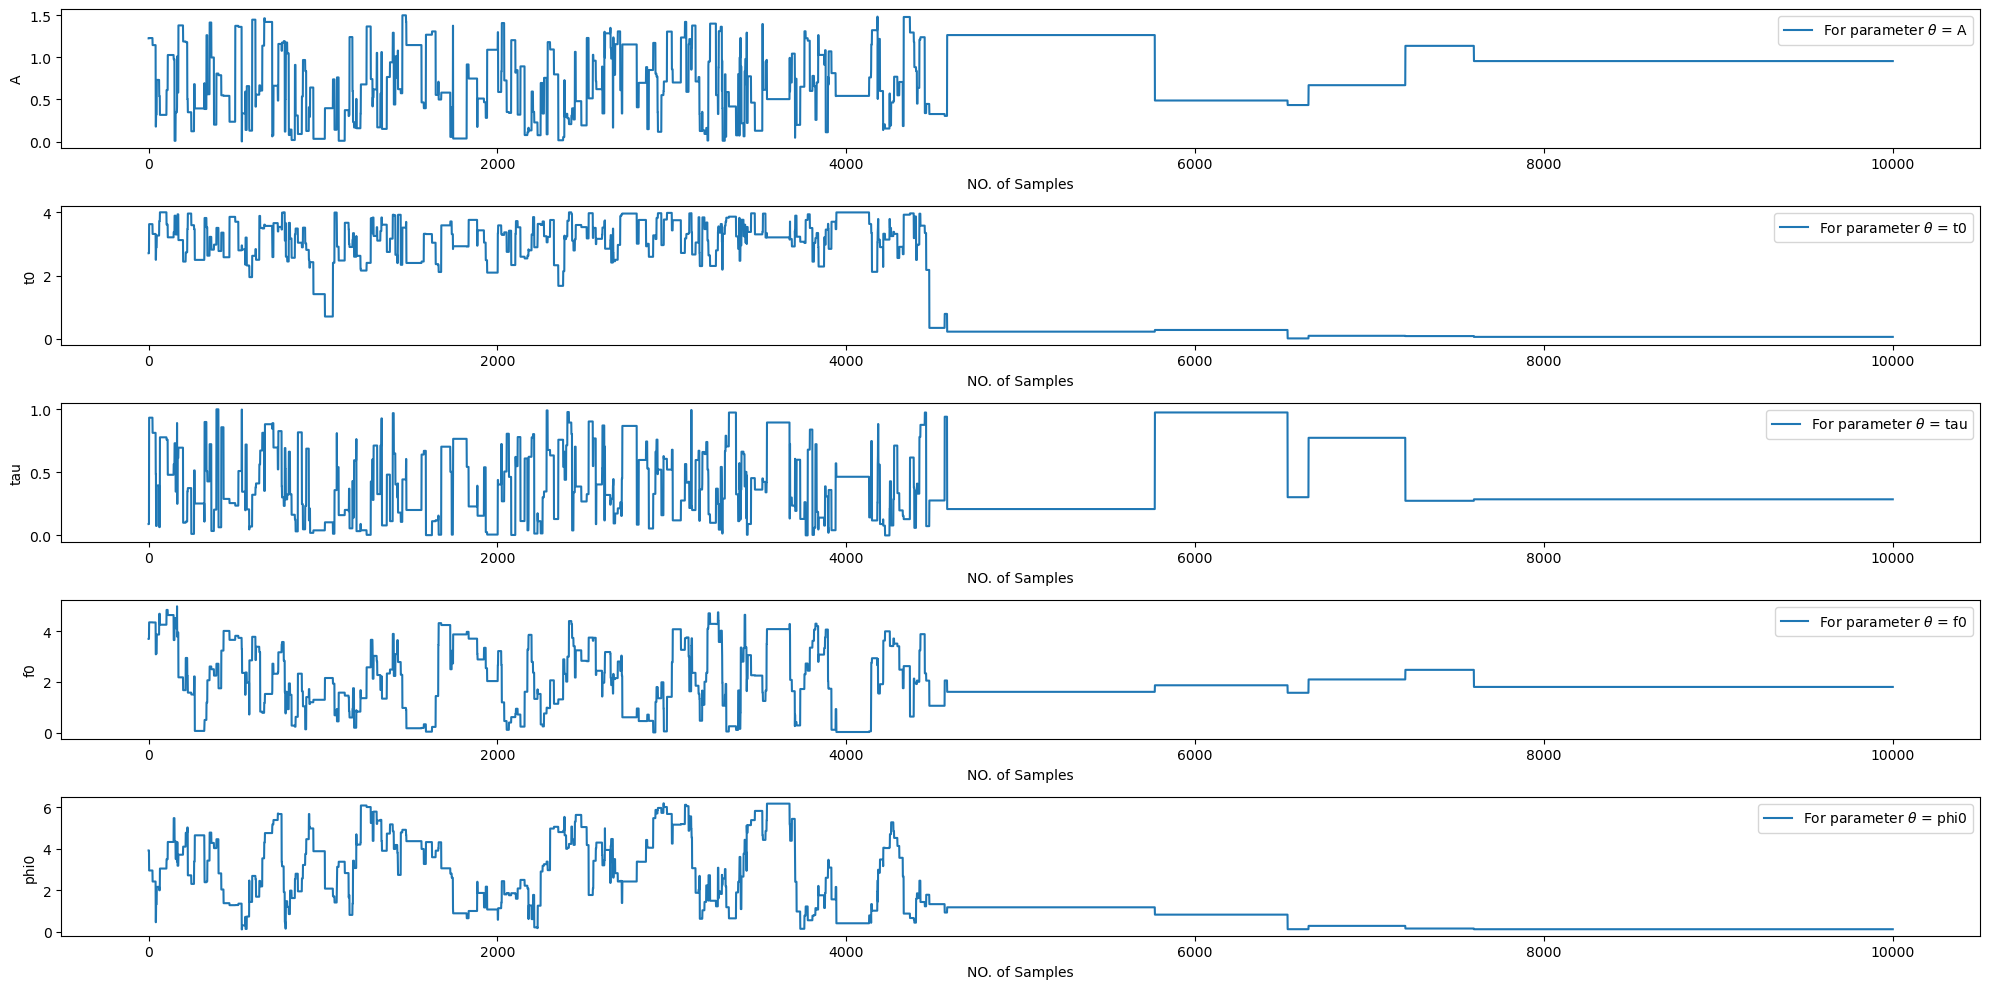

In [253]:
theta_init = [0.4, 2.0, 0.5, 2.0, np.pi]


samples, accepted , Theta_currents , Theta_proposeds = metropolis_hastings(log_posterior_A, theta_init, 10000, 0.9, t, d_t)

fig = plt.figure(figsize=(20 , 10))
labels=["A", "t0", "tau", "f0", "phi0"]
for i in range(5):
    ax = fig.add_subplot(5 ,1 ,i+1)
    ax.plot(samples[:,i] , label = f'For parameter $ \\theta $ = {labels[i]}' )
    ax.set_xlabel('NO. of Samples')
    ax.set_ylabel(f'{labels[i]}')
    ax.legend()
plt.tight_layout()
plt.show()

In [255]:
#### -- Plot samples for different parameters

In [257]:
##### Here we can see that after initial burn in phase our parameter value becomes stable( Not fluctuating too much ). Hence we can sample our parameter values after burn in phase

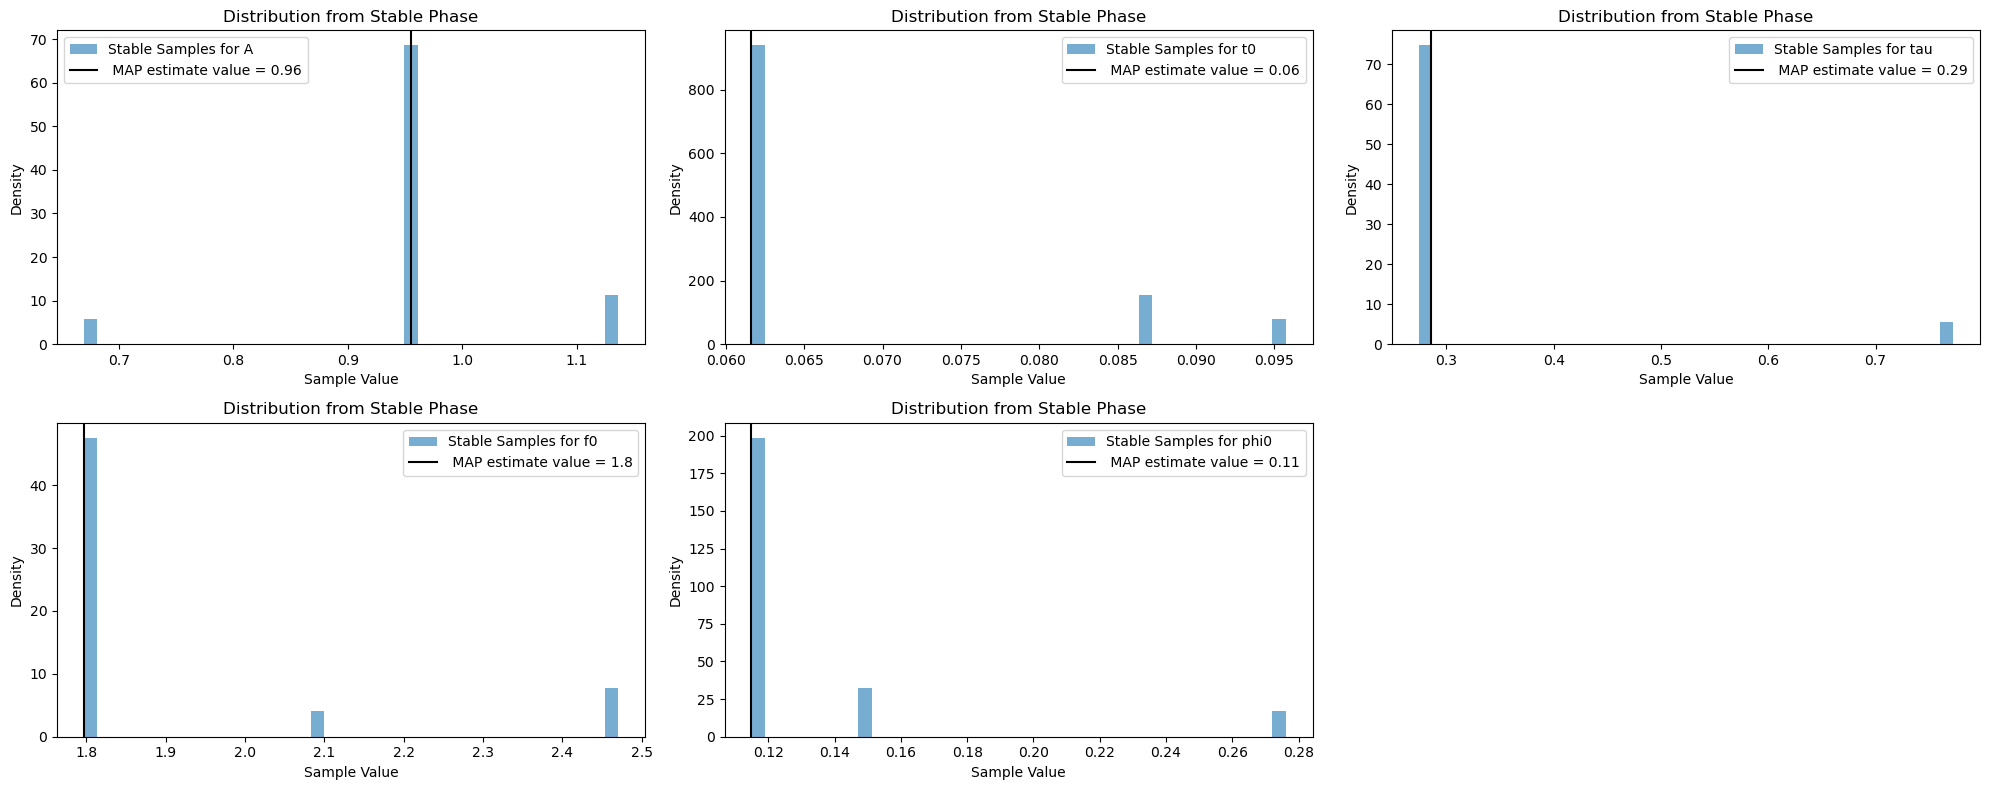

In [259]:
# -- map values based on maximizing the posterior dist
map_estimate_gaussian = samples[np.argmax([log_posterior_A(s, t, d_t) for s in samples])]

burn_in = 7000

labels=["A", "t0", "tau", "f0", "phi0"]
Mean_param_gaussian = []
Std_param = []

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    stable_samples = samples[burn_in: , i]
    Mean_param_gaussian.append(np.mean(stable_samples))
    Std_param.append(np.std(stable_samples))
    ax = fig.add_subplot(2 , 3 , i+1)
    ax.hist(stable_samples, bins=40, density=True, alpha=0.6, label=f"Stable Samples for {labels[i]} ")
    ax.axvline(x = map_estimate_gaussian[i] , color = 'black', label = f' MAP estimate value = {round(map_estimate_gaussian[i] , 2)}')
    ax.set_title("Distribution from Stable Phase")
    ax.set_xlabel("Sample Value")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
plt.show()


In [261]:
### -- Ploting (Different Choice of Prior Case)

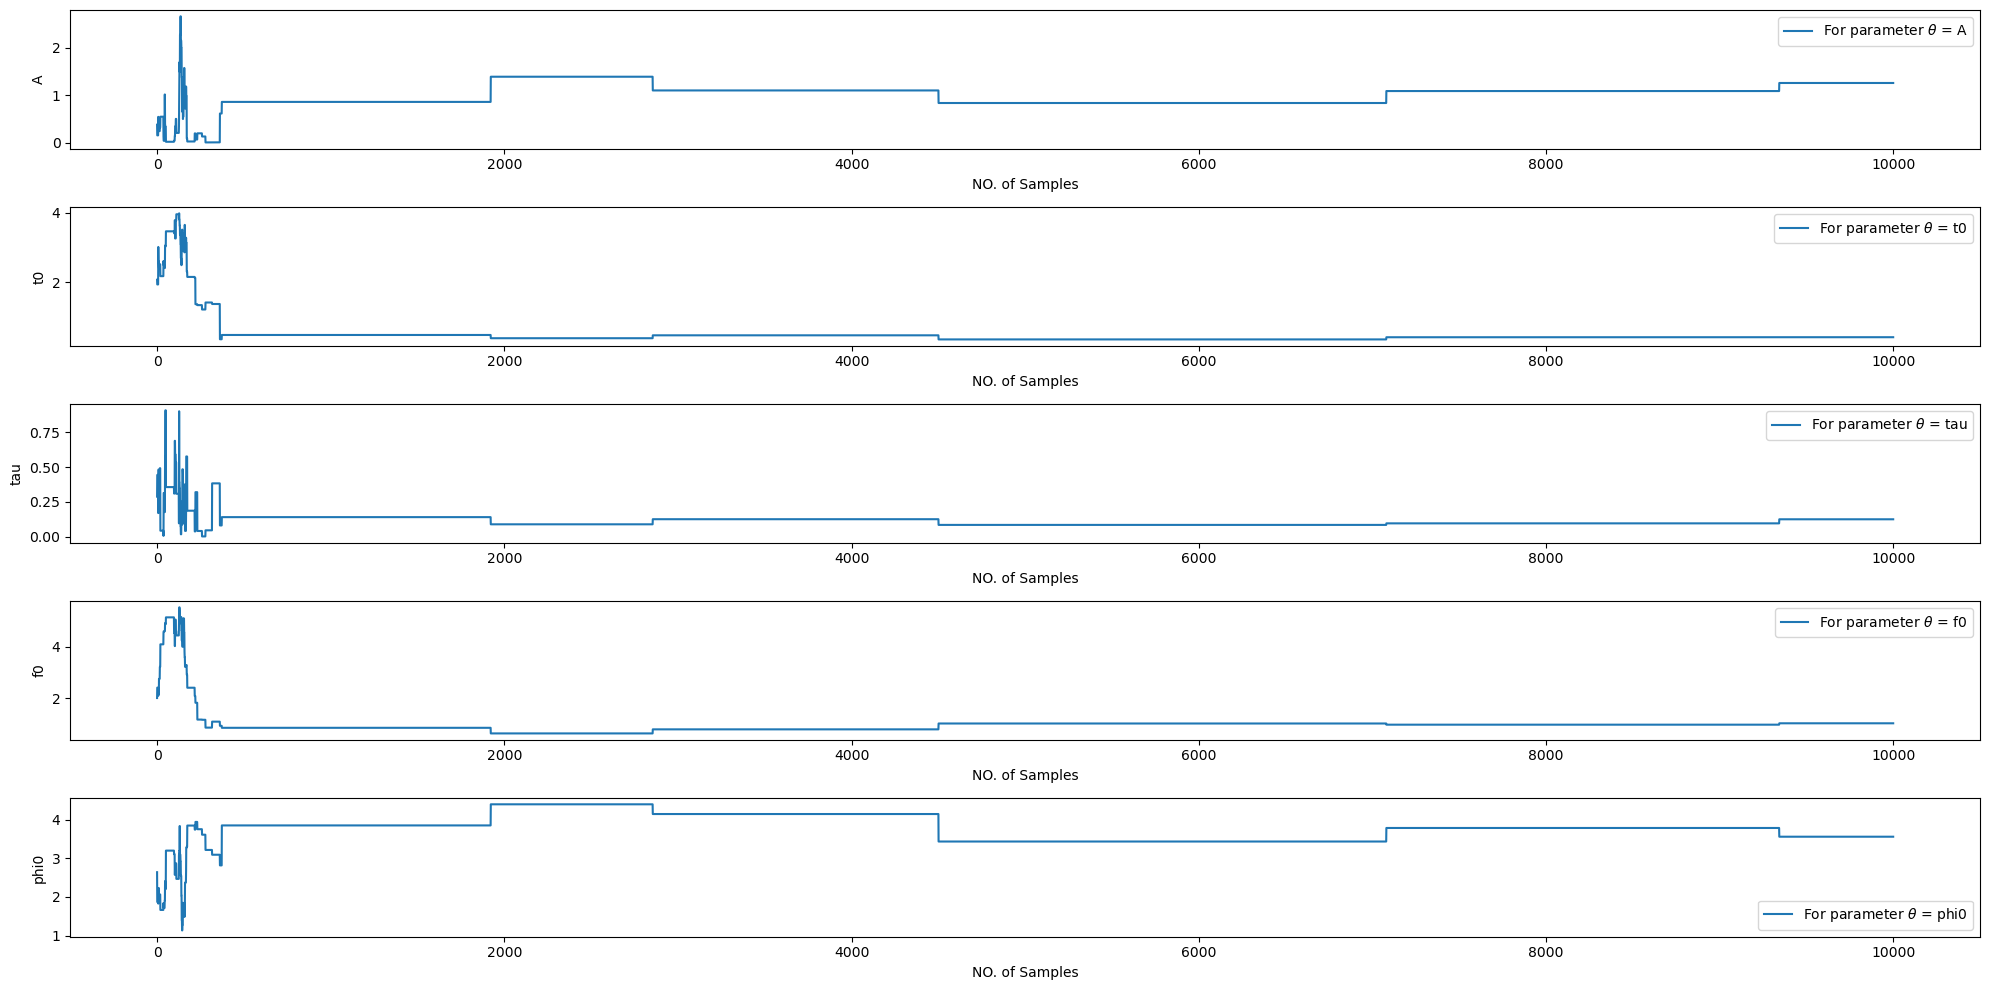

In [263]:
samples_B, accepted_B, Theta_currents_B , Theta_proposeds_B = metropolis_hastings(log_posterior_B, theta_init, 10000, 0.4, t, d_t)

fig = plt.figure(figsize=(20 , 10))
labels=["A", "t0", "tau", "f0", "phi0"]
for i in range(5):
    ax = fig.add_subplot(5 ,1 ,i+1)
    ax.plot(samples_B[:,i] , label = f'For parameter $ \\theta $ = {labels[i]}' )
    ax.set_xlabel('NO. of Samples')
    ax.set_ylabel(f'{labels[i]}')
    ax.legend()
plt.tight_layout()
plt.show()

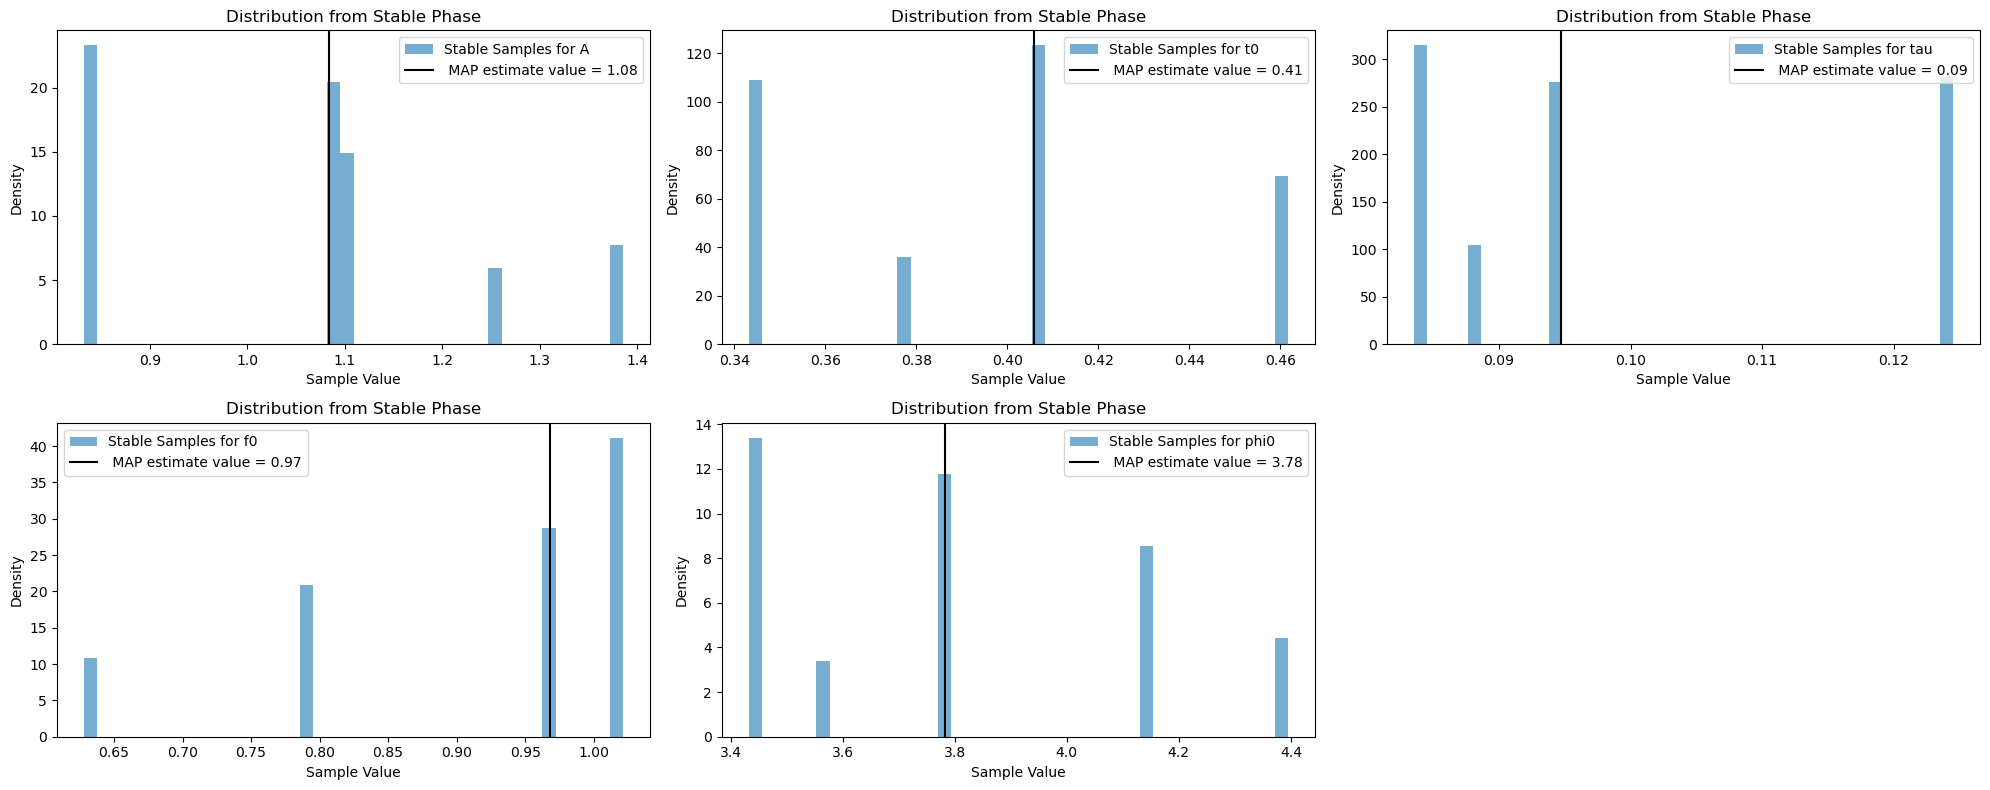

In [265]:
# -- map values based on maximizing the posterior dist
map_estimate_B = samples_B[np.argmax([log_posterior_B(s, t, d_t) for s in samples])]

burn_in = 2000

labels=["A", "t0", "tau", "f0", "phi0"]
Mean_param_B = []
Std_param_B = []

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    stable_samples = samples_B[burn_in: , i]
    Mean_param_B.append(np.mean(stable_samples))
    Std_param_B.append(np.std(stable_samples))
    ax = fig.add_subplot(2 , 3 , i+1)
    ax.hist(stable_samples, bins=40, density=True, alpha=0.6, label=f"Stable Samples for {labels[i]} ")
    ax.axvline(x = map_estimate_B[i] , color = 'black', label = f' MAP estimate value = {round(map_estimate_B[i] , 2)}')
    ax.set_title("Distribution from Stable Phase")
    ax.set_xlabel("Sample Value")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
plt.show()


In [267]:
### -- Plot actual sine-gaussian model with added noise and the estimated model with sampled values of parameters

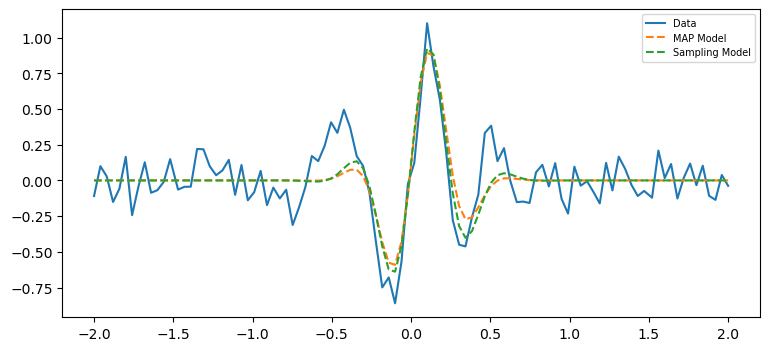

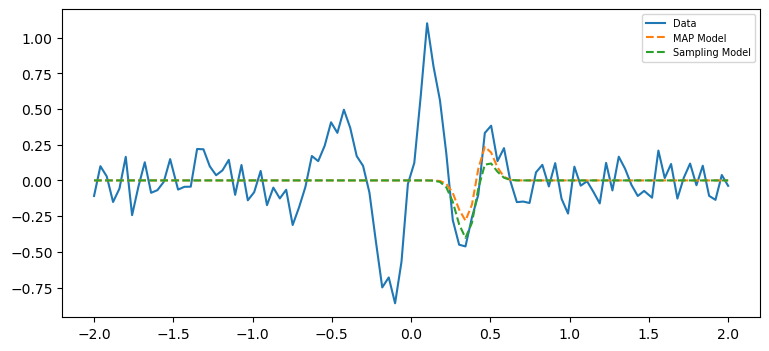

In [271]:
plt.figure(figsize=(9,4))
plt.plot(t, d_t, label="Data")
plt.plot(t, sine_gaussian(t, *map_estimate_gaussian), label="MAP Model", linestyle="--")
plt.plot(t ,sine_gaussian(t, *Mean_param_gaussian), label="Sampling Model", linestyle="--")
plt.legend(fontsize = 7)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(t, d_t, label="Data")
plt.plot(t, sine_gaussian(t, *map_estimate_B), label="MAP Model", linestyle="--")
plt.plot(t ,sine_gaussian(t, *Mean_param_B), label="Sampling Model", linestyle="--")
plt.legend(fontsize = 7)
plt.show()

In [273]:
### -- Plot corner plot

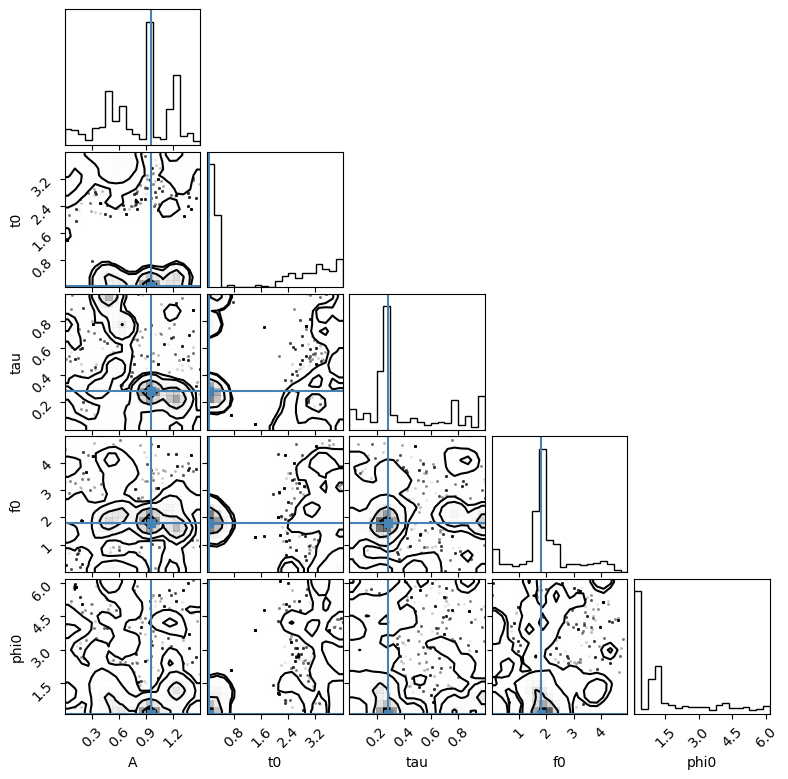

In [275]:
fig = plt.figure(figsize=(8,8)) 
plt.close()

corner.corner(
    samples,
    labels=["A", "t0", "tau", "f0", "phi0"],
    truths=map_estimate_gaussian,
    smooth=1,
    fig=fig )